#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час

## Подготовка

### Импорт библиотек

In [2]:
import time
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, 
                                      TimeSeriesSplit)

from sklearn.linear_model import (LinearRegression, Ridge)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose

from phik import phik_matrix
from phik.report import plot_correlation_matrix

### Подготовка данных 

In [4]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.isnull().sum()

num_orders    0
dtype: int64

In [6]:
data.index.is_monotonic

True

In [7]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Для работы предоставлены данные за полгода: с 1 марта по 31 августа. Данные расположены в хронологическом порядке, пропуски отсутствуют.
В процессе загрузки датасета мы привели дату к корректному типу и вынесли в индексы. Исходный датасет имеет 26496 строк с разбиением количества заказов на каждые 10 минут.

Теперь выполним ресемплирование данных с агрегированием по одному часу:

In [8]:
data = data.resample('1H').sum()

В целях дополнительной экономии памяти, снизим разрядность у признака num_orders с int64 до int32

In [9]:
data['num_orders'] = data['num_orders'].astype('int32') 

In [10]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int32
dtypes: int32(1)
memory usage: 51.8 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Полученный датасет содержит 4416 строк и готов к анализу. 

## Анализ

Посмотрим на исходный график временного ряда и график скользящего среднего. Отмечаем постепенный рост количества заказов к осени.

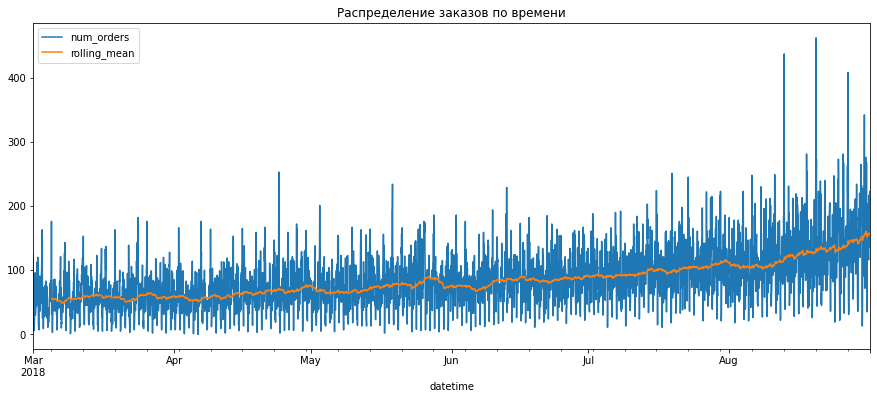

In [11]:
df = data.copy() 
df['rolling_mean'] = df.rolling(100).mean() 
df.plot(figsize=(15, 6), title='Распределение заказов по времени')
None

### Тренд

Text(0.5, 1.0, 'Trend')

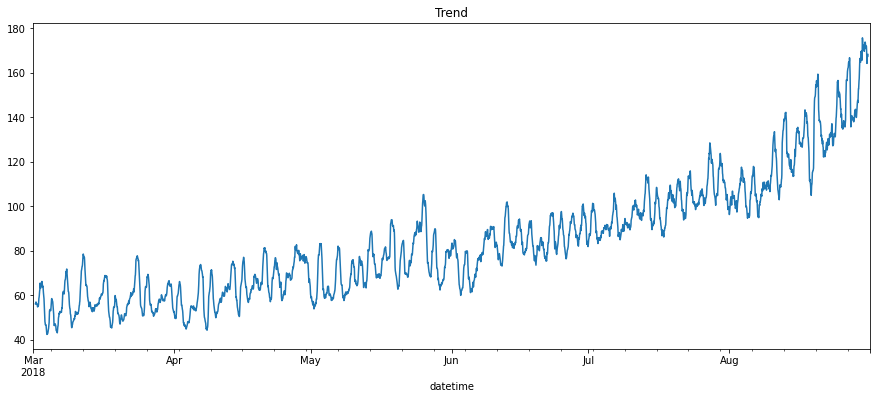

In [12]:
# Декомпозиция временного ряда
decomposed = seasonal_decompose(data) 

# Построение графика
plt.figure(figsize=(15, 6))
decomposed.trend.plot()
plt.title('Trend')


### Сезонность

#### Дневная сезонность

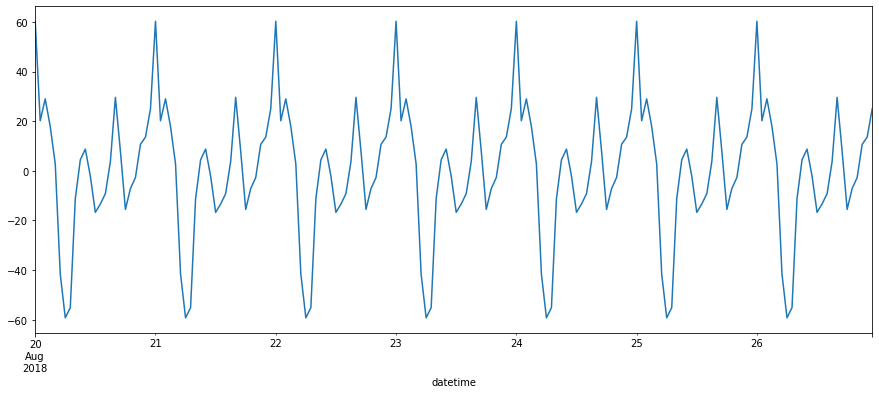

In [13]:
# Декомпозиция временного ряда
decomposed = seasonal_decompose(data)

# Извлечение сезонной компоненты
seasonal_component = decomposed.seasonal['2018-08-20':'2018-08-26']

# Построение графика
plt.figure(figsize=(15, 6))
seasonal_component.plot()
None

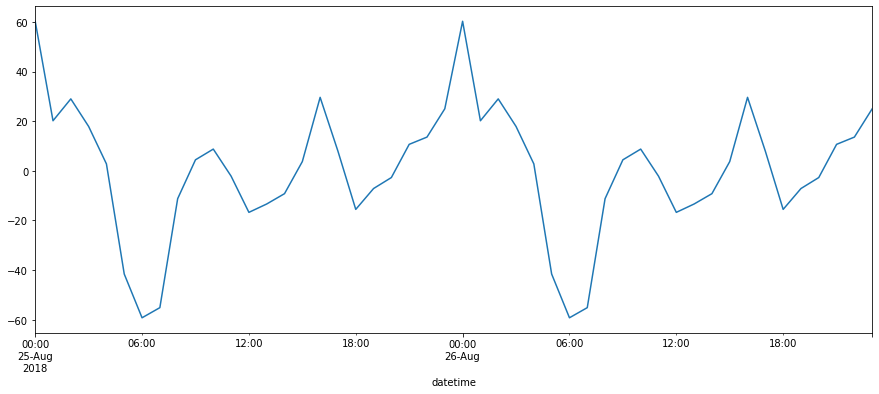

In [14]:
# Извлечение сезонной компоненты
seasonal_component = decomposed.seasonal['2018-08-25':'2018-08-26']

# Построение графика
plt.figure(figsize=(15, 6))
seasonal_component.plot()
None

Прослеживается явная дневная сезонность. Можем увидеть, что больше всего заказов поступает в полночь, а с 6 до 7 принимается наименьшее количество заказов. 

#### Недельная сезонность

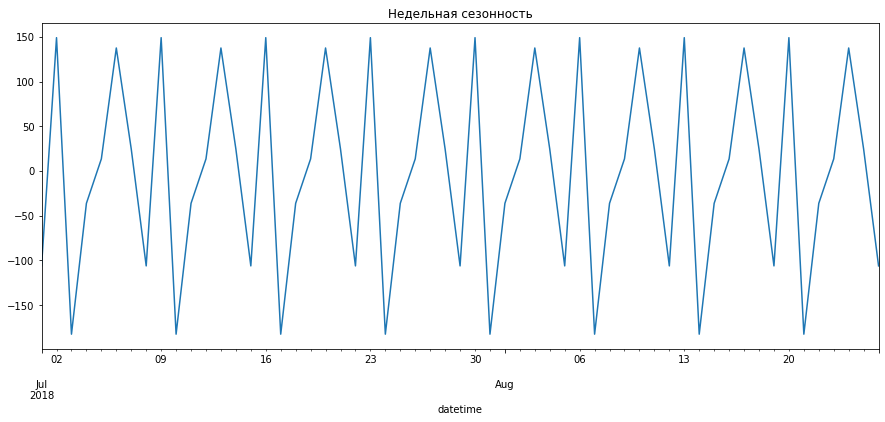

In [15]:
# Ресемплирование данных с агрегированием по дням
data_week = data.resample('1D').sum()


# Декомпозиция временного ряда
decomposed = seasonal_decompose(data_week)

# Извлечение сезонной компоненты
seasonal_component = decomposed.seasonal['2018-07-01':'2018-08-26']

# Построение графика
plt.figure(figsize=(15, 6))
plt.title('Недельная сезонность')
seasonal_component.plot()
None

На графике прослеживается наличие недельной сезонности.

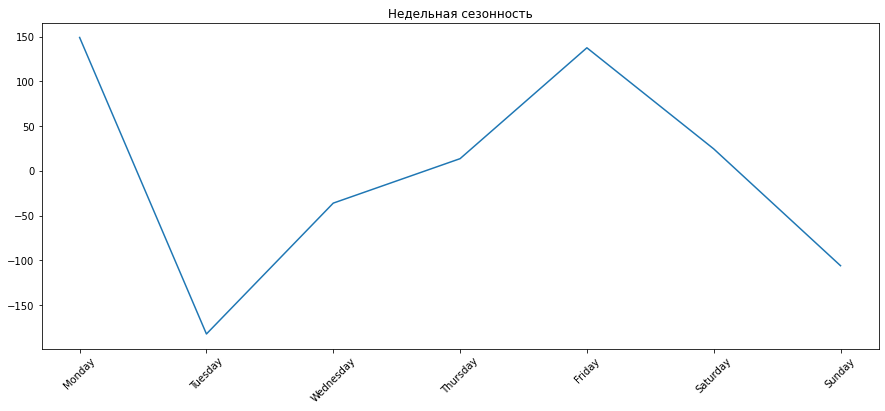

In [16]:
seasonal_component = decomposed.seasonal['2018-08-20':'2018-08-26']

# Добавление столбца с днем недели
data_week['day_of_week'] = data_week.index.day_name()

# Декомпозиция временного ряда (анализируем столбец 'num_orders')
decomposed = seasonal_decompose(data_week['num_orders'], period=7)

# Извлечение сезонной компоненты
seasonal_component = decomposed.seasonal['2018-08-20':'2018-08-26']

# Создание DataFrame для сезонной компоненты и добавление дней недели
seasonal_df = pd.DataFrame(seasonal_component)
seasonal_df['day_of_week'] = seasonal_df.index.day_name()

# Построение графика
plt.figure(figsize=(15, 6))
plt.plot(seasonal_df.index, seasonal_df['seasonal'])
plt.xticks(seasonal_df.index, seasonal_df['day_of_week'], rotation=45)
plt.title('Недельная сезонность')

plt.show()

Больше всего такси заказывают в понедельник и пятницу. Реже всего — во вторник.

### Создание признаков и корреляционный анализ

Добавим новые признаки в датасет

In [17]:
def make_features(dataframe, max_lag, rolling_mean_size):
    data = dataframe.copy(deep=True)
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

data = make_features(data, 28, 7)

In [18]:
data.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Выводы


1. В работе имеется датасет с данными за полгода с марта по август.
2. В распределении заказов прослеживается растущий тренд: ближе к осени клиенты делают больше заказов.
3. Имеется дневная и недельная сезонность. Чаще всего такси заказывают в полночь, реже всего — в 6 часов утра. Наибольшая загруженность в такси выпадает на понедельник и пятницу, меньше всего заказов принимается во вторник и субботу.
4. С учетом сезонности созданы дополнительные признаки. После анализа корреляций избыточные признаки удалены из датасета.


In [19]:
data.shape

(4416, 32)

## Обучение

### Подготовка к обучению

In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [21]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']


In [22]:
def rmse(y_train, y_pred):
    return (mean_squared_error(y_train, y_pred))**0.5

rmse_score = make_scorer(rmse, greater_is_better=False)

In [23]:
# TimeSeriesSplit для корректной кроссвалидации временного ряда
tscv = TimeSeriesSplit(n_splits=5)


### Ridge

In [24]:
# Словарь гиперпараметров
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0]}

#Инициализация модели
ridge = Ridge(random_state=12345)

# Инициализация GridSearchCV и запуск поиска
grid_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=tscv, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_ridge.fit(X_train, y_train)

# Лучшие параметры и метрики
best_params_ridge = grid_ridge.best_params_
best_score_ridge = -grid_ridge.best_score_
cv_results_ridge = pd.DataFrame(grid_ridge.cv_results_)

# Вывод результатов
print("Результаты на валидационной выборке для Ridge Regressor:")
print("Лучшие параметры:", best_params_ridge)
print("RMSE:", best_score_ridge.round(2))
print("Время обучения:", cv_results_ridge['mean_fit_time'].min().round(4))
print("Время предсказания:", cv_results_ridge['mean_score_time'].min().round(4))

Результаты на валидационной выборке для Ridge Regressor:
Лучшие параметры: {'alpha': 10.0}
RMSE: 26.94
Время обучения: 0.0593
Время предсказания: 0.021


### RandomForestRegressor

In [25]:
# Словарь гиперпараметров
param_grid_rf = {
    'n_estimators': [10, 15, 20],
    'max_depth': [5, 10, 20],
    'max_features': [3, 6, 9]
}

#Инициализация модели
rf = RandomForestRegressor(random_state=12345)

# Инициализация GridSearchCV и запуск поиска
grid_rf = GridSearchCV(estimator=rf, 
                       param_grid=param_grid_rf, 
                       cv=tscv, 
                       scoring='neg_root_mean_squared_error', 
                       return_train_score=True)
grid_rf.fit(X_train, y_train)

# Лучшие параметры и метрики
best_params_rf = grid_rf.best_params_
best_score_rf = -grid_rf.best_score_
cv_results_rf = pd.DataFrame(grid_rf.cv_results_)

# Вывод результатов
print("Результаты на валидационной выборке RandomForest Regressor:")
print("Лучшие параметры:", best_params_rf)
print("RMSE:", best_score_rf.round(2))
print("Время обучения:", cv_results_rf['mean_fit_time'].min().round(4))
print("Время предсказания:", cv_results_rf['mean_score_time'].min().round(4))

Результаты на валидационной выборке RandomForest Regressor:
Лучшие параметры: {'max_depth': 20, 'max_features': 6, 'n_estimators': 20}
RMSE: 25.94
Время обучения: 0.027
Время предсказания: 0.0035


### GradientBoostingRegressor

In [26]:
# Словарь гиперпараметров
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

#Инициализация модели
gb = GradientBoostingRegressor()

# Инициализация GridSearchCV и запуск поиска
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=tscv, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_gb.fit(X_train, y_train)

# Лучшие параметры и метрики
best_params_gb = grid_gb.best_params_
best_score_gb = -grid_gb.best_score_
cv_results_gb = pd.DataFrame(grid_gb.cv_results_)

# Вывод результатов для GradientBoosting
print("Результаты на валидационной выборке GradientBoosting Regressor:")
print("Лучшие параметры:", best_params_gb)
print("RMSE:", best_score_gb.round(2))
print("Время обучения:", cv_results_gb['mean_fit_time'].min().round(4))
print("Время предсказания:", cv_results_gb['mean_score_time'].min().round(4))

Результаты на валидационной выборке GradientBoosting Regressor:
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
RMSE: 25.51
Время обучения: 0.4896
Время предсказания: 0.0028


### DecisionTreeRegressor

In [27]:
# Словарь гиперпараметров
param_grid_dt = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

#Инициализация модели
dt = DecisionTreeRegressor(random_state=12345)

# Инициализация GridSearchCV и запуск поиска
grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=tscv, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_dt.fit(X_train, y_train)

# Лучшие параметры и метрики
best_params_dt = grid_dt.best_params_
best_score_dt = -grid_dt.best_score_
cv_results_dt = pd.DataFrame(grid_dt.cv_results_)

# Вывод результатов для DecisionTree
print("Результаты на валидационной выборке DecisionTree Regressor:")
print("Лучшие параметры:", best_params_dt)
print("RMSE:", best_score_dt.round(2))
print("Время обучения:", cv_results_dt['mean_fit_time'].min().round(4))
print("Время предсказания:", cv_results_dt['mean_score_time'].min().round(4))

Результаты на валидационной выборке DecisionTree Regressor:
Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
RMSE: 29.57
Время обучения: 0.0187
Время предсказания: 0.0019


### LGBMRegressor

In [28]:
# Словарь гиперпараметров
param_grid_lgb = {
    'num_leaves': [20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [30, 50, 70]
}

#Инициализация модели
lgbm = lgb.LGBMRegressor(random_state=12345)

# Инициализация GridSearchCV и запуск поиска
grid_lgb = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgb, cv=tscv, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_lgb.fit(X_train, y_train)

# Лучшие параметры и метрики
best_params_lgb = grid_lgb.best_params_
best_score_lgb = -grid_lgb.best_score_
cv_results_lgb = pd.DataFrame(grid_lgb.cv_results_)

# Вывод результатов 
print("Результаты на валидационной выборке LGBM Regressor:")
print("Лучшие параметры:", best_params_lgb)
print("RMSE:", best_score_lgb.round(2))
print("Время обучения:", cv_results_lgb['mean_fit_time'].min().round(4))
print("Время предсказания:", cv_results_lgb['mean_score_time'].min().round(4))

Результаты на валидационной выборке LGBM Regressor:
Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 70, 'num_leaves': 20}
RMSE: 25.4
Время обучения: 0.4144
Время предсказания: 0.0034


In [29]:
# Создание таблицы результатов
results = pd.DataFrame({
    'Модель': ['Ridge', 'RandomForest', 'GradientBoosting', 'DecisionTree', 'LGBM'],
    'RMSE': [best_score_ridge, best_score_rf, best_score_gb, best_score_dt, best_score_lgb],
    'Время обучения': [
        cv_results_ridge['mean_fit_time'].min(),
        cv_results_rf['mean_fit_time'].min(),
        cv_results_gb['mean_fit_time'].min(),
        cv_results_dt['mean_fit_time'].min(),
        cv_results_lgb['mean_fit_time'].min()
    ],
    'Время предсказания': [
        cv_results_ridge['mean_score_time'].min(),
        cv_results_rf['mean_score_time'].min(),
        cv_results_gb['mean_score_time'].min(),
        cv_results_dt['mean_score_time'].min(),
        cv_results_lgb['mean_score_time'].min()
    ]
})

results

,Модель,RMSE,Время обучения,Время предсказания
0,Ridge,26.942526,0.059347,0.020995
1,RandomForest,25.935306,0.027049,0.003480
2,GradientBoosting,25.505637,0.489639,0.002791
3,DecisionTree,29.573860,0.018748,0.001882
4,LGBM,25.403573,0.414431,0.003391


## Тестирование

Все модели показали хорошую точность, скорость обучения и предсказаний. Наилучший показатель RMSE при незначительной разнице по времени, получен для модели GradientBoosting. Проверим метрику модели на тестовой выборке.

In [30]:
# Получаем лучшую модель из GridSearchCV
best_gb = grid_gb.best_estimator_

# Предсказание на тестовой выборке
y_pred = best_gb.predict(X_test)

rmse_test = (mean_squared_error(y_test, y_pred))**0.5

print("RMSE на тестовой выборке:", rmse_test.round(2))

RMSE на тестовой выборке: 42.98


In [31]:
model_dr = DummyRegressor()
model_dr.fit(X_train, y_train)
dumy_pred = model_dr.predict(X_test)
dumy_test_rmse = mean_squared_error(y_test, dumy_pred, squared=False)
print('RMSE Dummy модели:', np.round(dumy_test_rmse, 0))

RMSE Dummy модели: 85.0


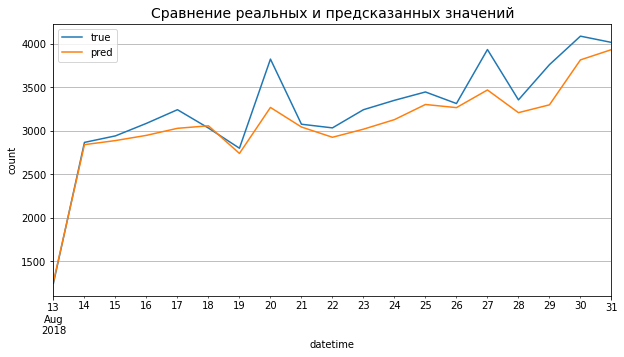

In [32]:
df_result = pd.DataFrame(y_test)
df_result['pred'] = np.round(y_pred, 0)
df_result.columns = ['true', 'pred']
df_result.resample('1D').sum().plot(figsize=(10, 5), grid=True)
plt.title('Сравнение реальных и предсказанных значений', fontsize=14)
plt.ylabel('count')
plt.show()

Модель продемонстрировала удовлетворительный результат на тестовой выборке. При этом, модель GradientBoosting показывает значительно лучший результат, чем константная модель. 

По графику видно, что модель слегка недооценивает значения. Это может быть связано с тем, что модель обучается на данных с растущим трендом. При этом, данных может быть недостаточно, чтобы уловить все закономерности. Расширение выборки, настройка гиперпараметров или добавление новых признаков могли бы улучшить точность модели. 

Тем не менее, данной точности достаточно по условиям задачи, поэтому она рекомендуется для прогнозирования количества заказов такси. 